## Importing Modules

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
male_images = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/animefacedataset/images",
    labels=None,
    batch_size=1
).take(1000)
female_images = tf.keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/human-faces/Humans",
    labels=None,
    batch_size=1
).take(1000)

Found 63565 files belonging to 1 classes.
Found 7219 files belonging to 1 classes.


In [3]:
male_images.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1000>

In [46]:
for image in male_images.take(1):
    male_img = image
for image in female_images.take(1):
    female_img = image

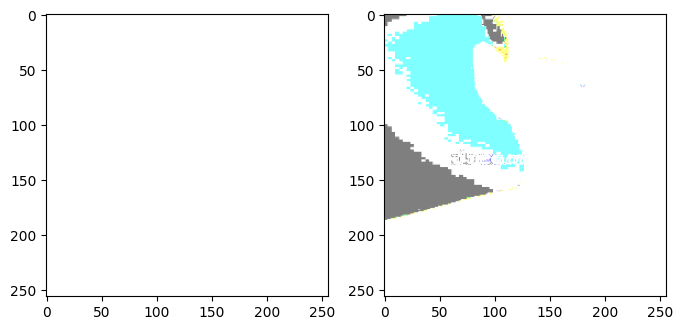

In [5]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(male_img[0]*0.5+0.5)
plt.subplot(122)
plt.imshow(female_img[0]*0.5+0.5)

## Data Preprocessing

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [7]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
      image[0], size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [8]:
male_images = male_images.cache().map(
    preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

female_images = female_images.cache().map(
    preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
OUTPUT_CHANNELS=3

In [10]:
def downsample(filters, size, strides=2, apply_batchnorm=True, leaky_relu=None, padding=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    if padding:
        result.add(
            tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    else:
        result.add(
            tf.keras.layers.Conv2D(filters, size, strides=strides, padding='valid',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    if leaky_relu is True:
        result.add(tf.keras.layers.LeakyReLU())
    elif leaky_relu is False:
        result.add(tf.keras.layers.ReLU())
    return result

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [12]:
def resnet_block():
    result = tf.keras.models.Sequential()
    result.add(downsample(256,3,strides=1,apply_batchnorm=True,leaky_relu=False))
    result.add(downsample(256,3,strides=1,apply_batchnorm=True,leaky_relu=None))
    return result

In [13]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64,7,strides=1,apply_batchnorm=False,leaky_relu=True),
        downsample(128,3,strides=2,apply_batchnorm=True,leaky_relu=True),
        downsample(256,3,strides=2,apply_batchnorm=True,leaky_relu=True),
    ]
    resnet_stack = [
        resnet_block()
    ]*9
    up_stack = [
        upsample(128,3),
        upsample(64,3),
    ]
    final_layer = downsample(3,7,strides=1,apply_batchnorm=False)
    
    x = inputs
    
    for down in down_stack:
        x = down(x)
    
    for res in resnet_stack:
        x = x + res(x)
        
    for up in up_stack:
        x = up(x)
        
    x = final_layer(x)
    return tf.keras.Model(inputs=inputs, outputs=x)
    

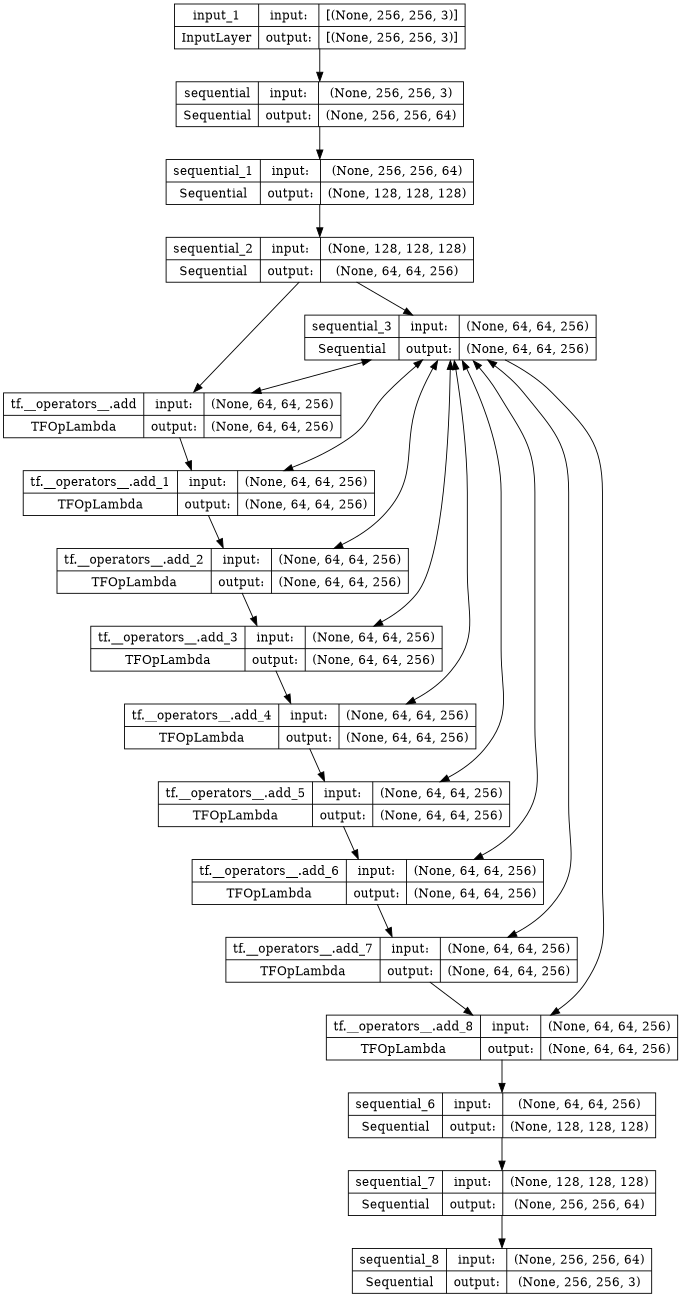

In [14]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

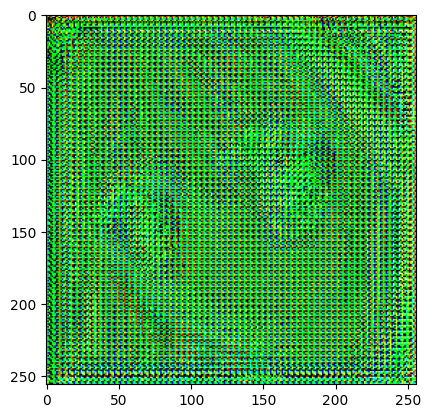

In [15]:
gen_output = generator(male_img, training=False)
plt.imshow(gen_output[0, ...])

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    x = inputs
    x = downsample(64,4,strides=2,apply_batchnorm=False,leaky_relu=True)(x)
    x = downsample(128,4,strides=2,apply_batchnorm=False,leaky_relu=True)(x)
    x = downsample(256,4,strides=2,apply_batchnorm=False,leaky_relu=True)(x)
    
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = downsample(512,4,strides=1,apply_batchnorm=False,leaky_relu=True,padding=False)(x)
    x = tf.keras.layers.ZeroPadding2D()(x)
    x = downsample(1,4,strides=1,apply_batchnorm=False,leaky_relu=True,padding=False)(x)
    
    return tf.keras.Model(inputs=inputs,outputs=x)
    

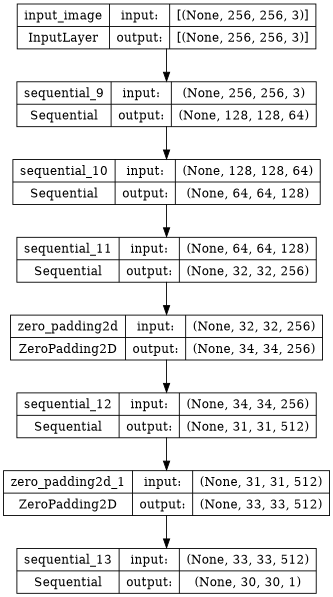

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [18]:
disc_out = discriminator(gen_output,training=False)
disc_out.shape

TensorShape([1, 30, 30, 1])

In [19]:
LAMBDA = 10

In [20]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [22]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [23]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [24]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [25]:
generator_m2f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f2m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
generator_m2f = Generator()
generator_f2m = Generator()

discriminator_f = Discriminator()
discriminator_m = Discriminator()

In [27]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_m2f=generator_m2f,
                           generator_f2m=generator_f2m,
                           discriminator_m=discriminator_m,
                           discriminator_f=discriminator_f,
                           generator_m2f_optimizer=generator_m2f_optimizer,
                           generator_f2m_optimizer=generator_f2m_optimizer,
                           discriminator_m_optimizer=discriminator_m_optimizer,
                           discriminator_f_optimizer=discriminator_f_optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# # if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)

In [36]:
@tf.function
def train_step(real_m, real_f):
    with tf.GradientTape(persistent=True) as tape:
        # Generator m2f translates m -> f
        # Generator f2m translates f -> m.
        fake_f = generator_m2f(real_m)
        fake_m = generator_f2m(real_f)
        
        recon_m = generator_f2m(fake_f)
        recon_f = generator_m2f(fake_m)
        
        same_f = generator_m2f(real_f)
        same_m = generator_f2m(real_m)
        
        disc_real_m = discriminator_m(real_m)
        disc_real_f = discriminator_f(real_f)
        
        disc_fake_m = discriminator_m(fake_m)
        disc_fake_f = discriminator_f(fake_f)
        
        generator_m2f_loss = generator_loss(disc_fake_f)
        generator_f2m_loss = generator_loss(disc_fake_m)
        
        total_cycle_loss = calc_cycle_loss(real_m,recon_m) + calc_cycle_loss(real_f,recon_f)
        
        total_gen_m2f_loss = generator_m2f_loss + total_cycle_loss + identity_loss(real_f,same_f)
        total_gen_f2m_loss = generator_f2m_loss + total_cycle_loss + identity_loss(real_m,same_m)
        
        disc_m_loss = discriminator_loss(disc_real_m,disc_fake_m)
        disc_f_loss = discriminator_loss(disc_real_f,disc_fake_f)
        
    gen_m2f_grads = tape.gradient(total_gen_m2f_loss,generator_m2f.trainable_variables)
    gen_f2m_grads = tape.gradient(total_gen_f2m_loss,generator_f2m.trainable_variables)
    
    disc_m_grads = tape.gradient(disc_m_loss,discriminator_m.trainable_variables)
    disc_f_grads = tape.gradient(disc_f_loss,discriminator_f.trainable_variables)
    
    generator_m2f_optimizer.apply_gradients(zip(gen_m2f_grads, 
                                            generator_m2f.trainable_variables))

    generator_f2m_optimizer.apply_gradients(zip(gen_f2m_grads, 
                                            generator_f2m.trainable_variables))

    discriminator_m_optimizer.apply_gradients(zip(disc_m_grads,
                                                discriminator_m.trainable_variables))

    discriminator_f_optimizer.apply_gradients(zip(disc_f_grads,
                                                discriminator_f.trainable_variables))

In [37]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

In [38]:
import time

In [39]:
EPOCHS = 75
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_m, image_f in tf.data.Dataset.zip((male_images, female_images)):
        train_step(image_m, image_f)
        if n % 10 == 0:
            print ('.', end='')
        n += 1

#     clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
#     generate_images(generator_f2m, female_img)

    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        print ('Saving checkpoint for epoch {} '.format(epoch+1))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

....................................................................................................Time taken for epoch 1 is 507.6857154369354 sec

....................................................................................................Time taken for epoch 2 is 487.8170669078827 sec

....................................................................................................Time taken for epoch 3 is 485.7458357810974 sec

....................................................................................................Time taken for epoch 4 is 484.7617118358612 sec

....................................................................................................Saving checkpoint for epoch 5 
Time taken for epoch 5 is 486.52189207077026 sec

....................................................................................................Time taken for epoch 6 is 487.13992834091187 sec

.........................................................................

In [51]:
checkpoint.restore(tf.train.latest_checkpoint('/kaggle/input/cyclegancheckpoint7'))

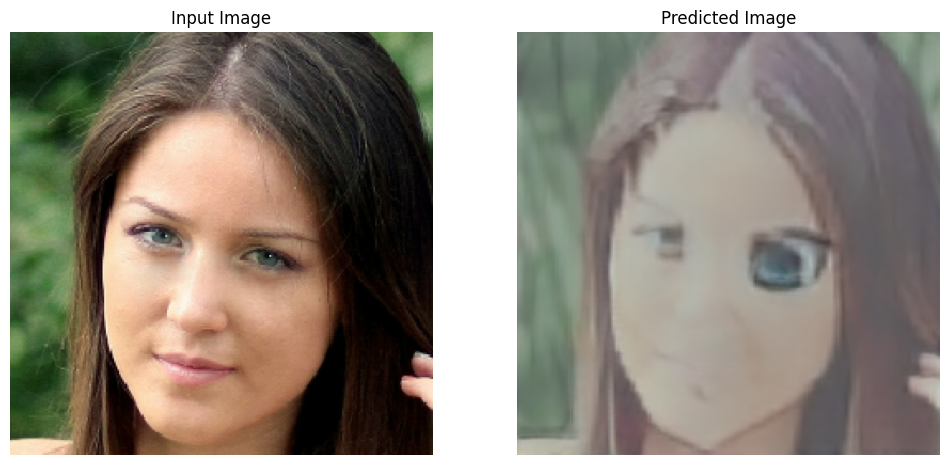

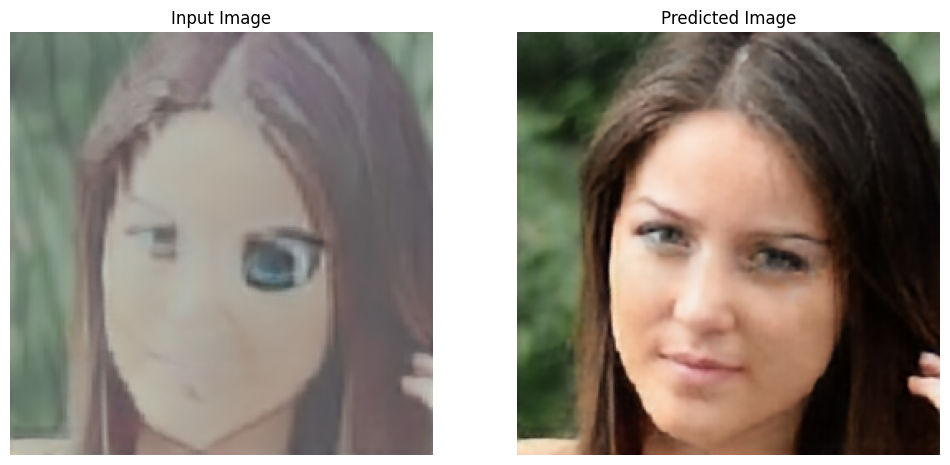

In [96]:
prediction = generator_f2m(female_img)
generate_images(generator_f2m, female_img)
generate_images(generator_m2f, prediction)

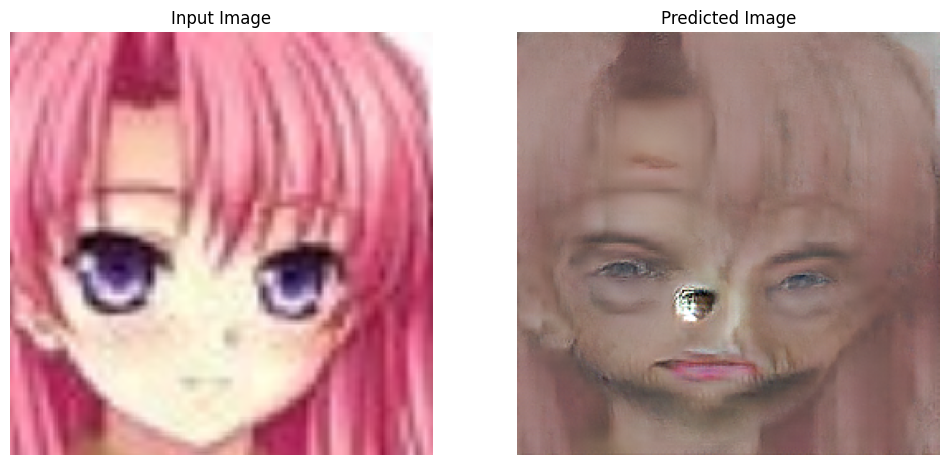

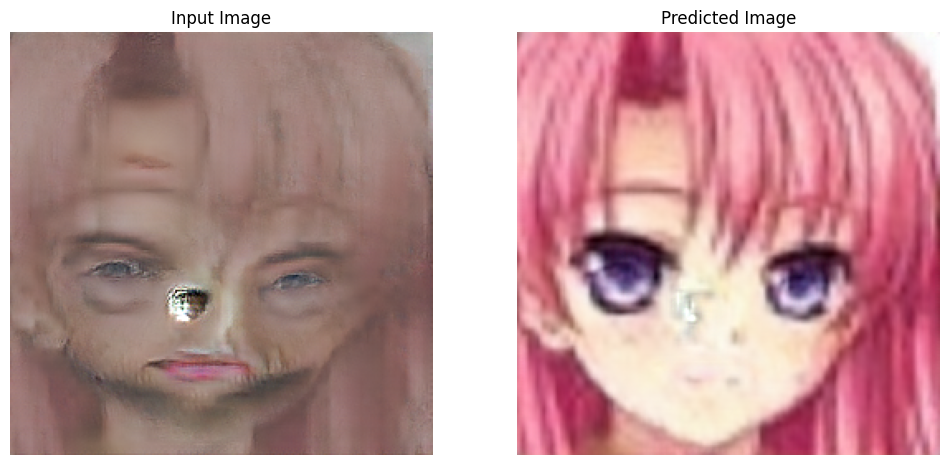

In [97]:
prediction = generator_m2f(male_img)
generate_images(generator_m2f, male_img)
generate_images(generator_f2m, prediction)

In [69]:
from PIL import Image

In [73]:
img = Image.open('/kaggle/input/my-img-inference/IMG_0312.JPG')

In [76]:
img = np.array(img)

In [78]:
img = np.reshape(img,(1,2448,3264,3))

In [79]:
new_img=preprocess_image_train(img)

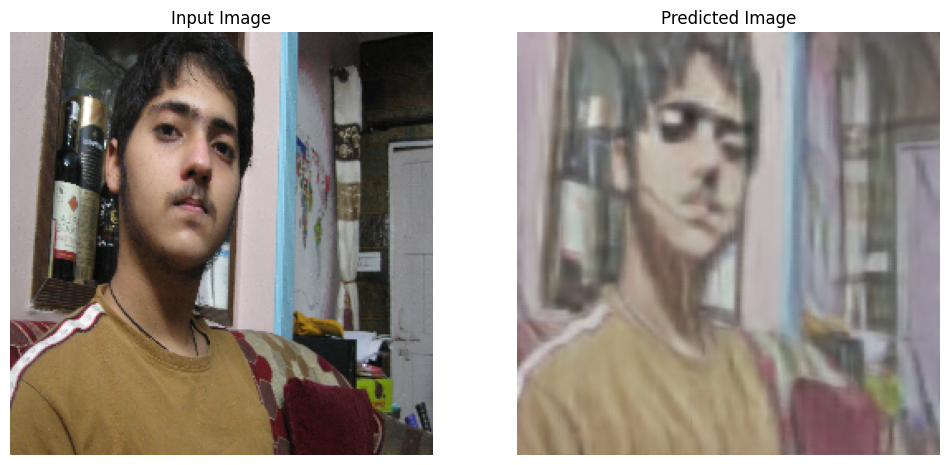

In [106]:
generate_images(generator_f2m,np.reshape(new_img,(1,256,256,3)))

In [113]:
for image in male_images.take(1):
    male_img = image
for image in female_images.take(1):
    female_img = image

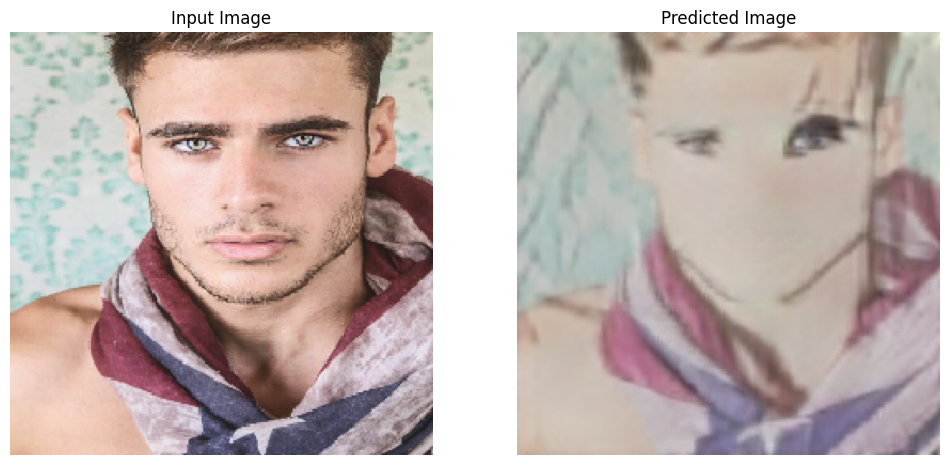

In [115]:
for i in range(12,13):
    with open('/kaggle/working/training_checkpoints/checkpoint','w') as f:
        f.write(f'''model_checkpoint_path: "ckpt-{i}"
    all_model_checkpoint_paths: "ckpt-{i}"
    ''')
    checkpoint.restore(tf.train.latest_checkpoint('/kaggle/working/training_checkpoints'))
    generate_images(generator_f2m, female_img)
    

In [116]:
generator_f2m.save('generator12.keras')

In [117]:
model = tf.keras.models.load_model('/kaggle/working/generator12.keras')

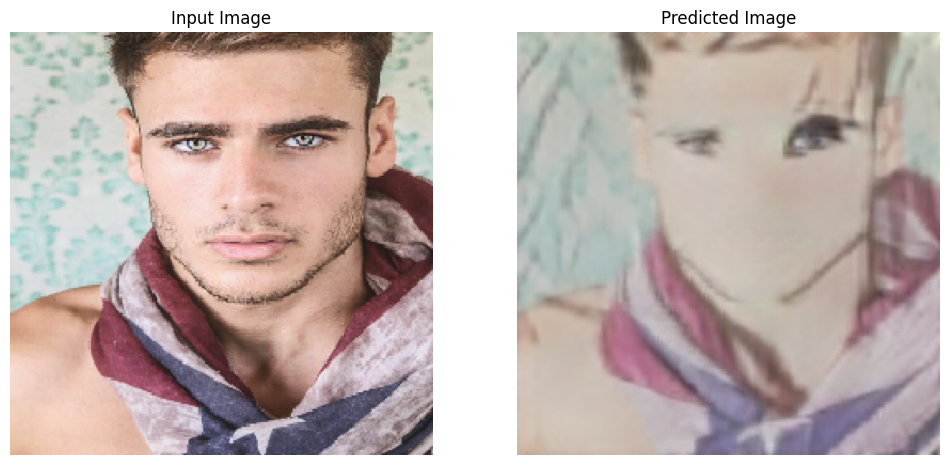

In [118]:
generate_images(model,female_img)